In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.fftpack import fft,ifft
import pandas as pd
from scipy.optimize import minimize
from iminuit import Minuit
from scipy.optimize import basinhopping
from scipy.optimize import curve_fit
import emcee
from pprint import pprint
import time

In [19]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata06 = pd.read_csv("perlist092.csv")
    f = perdata06['f']
    per = perdata06['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata06)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [20]:
m=Minuit(twi_minus_loglikelihood,log_A=-2,log_f_b=math.log(1.0E-4,10),alpha_H=3.8,poisson=0.8,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.01,error_poisson=0.01,
         limit_log_A=(-3,-1), limit_log_f_b=(-5,-3),limit_alpha_H=(1.5,5.0),limit_poisson=(0,2),
         errordef=1)

m.migrad()

pprint(m.fval)
m.print_param()

FCN = 2223.0679218809028 
 TOTAL NCALL = 223 
 NCALLS = 223 
 
 
 EDM = 4.914706494301288e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-1.22559,0.465731,,,-3,-1,No
1,log_f_b,-4.59023,0.461291,,,-5,-3,No
2,alpha_H,2.64898,0.346836,,,1.5,5,No
3,poisson,1.27595,0.0480262,,,0,2,No


2223.0679218809028


+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-1.22559,0.465731,,,-3,-1,No
1,log_f_b,-4.59023,0.461291,,,-5,-3,No
2,alpha_H,2.64898,0.346836,,,1.5,5,No
3,poisson,1.27595,0.0480262,,,0,2,No


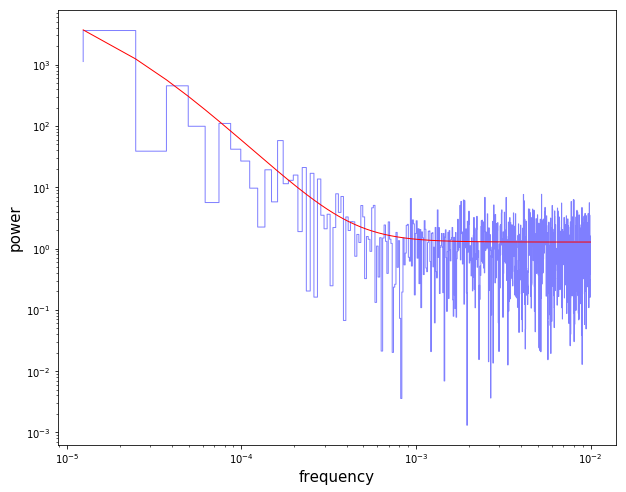

In [21]:
perdata091 = pd.read_csv("perlist092.csv")
f = perdata091['f']
per = perdata091['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m.values[0],m.values[1],m.values[2],m.values[3]

model = []
f_length = len(f)
for i in range(f_length):
    model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    
plt.figure(figsize=(10,8))
plt.loglog()
plt.step(f, per, color="b", alpha=0.5, linewidth=1)
plt.plot(f, model, color="r", linewidth=1)
plt.xlabel("frequency",fontsize=15)
plt.ylabel("power",fontsize=15)
plt.show()

In [22]:
# 均匀先验

def lnprior(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    alpha_L = 1.0
    if -3 < log_A < 0 and -6 < log_f_b < -3 and 1.0 < alpha_H < 4.0 and 0.0 < poisson < 3.0:
        return 0.0
    return -np.inf

# 后验概率？

def lnprob(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp - 0.5* twi_minus_loglikelihood(log_A,log_f_b,alpha_H,poisson))

In [23]:
# emcee

ndim, nwalkers = 4, 100
pos = [[m.values[0],m.values[1],m.values[2],m.values[3]] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)


# 显示进度并记录时间
import sys

nsteps = 500
width = 30
start = time.time()
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    z = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * z, ' ' * (width - z)))
sys.stdout.write("\n")
end = time.time()
multi_time = end - start
print("Serial took {0:.1f} seconds".format(multi_time))

[##############################]
Serial took 1080.0 seconds


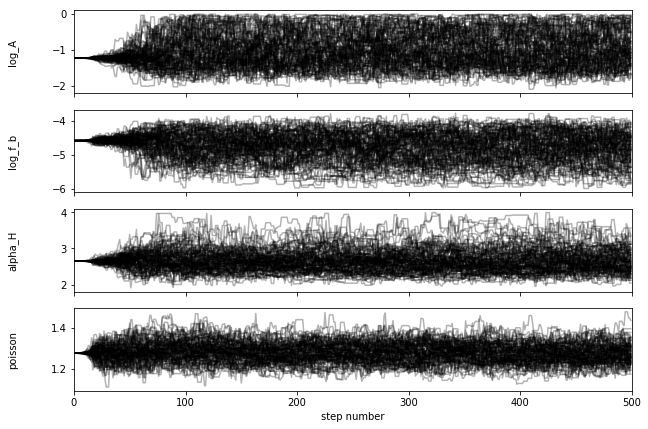

In [24]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["log_A", "log_f_b", "alpha_H","poisson"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.transpose(samples[:,:,i]), "k", alpha=0.3)
    ax.set_xlim(0, len(samples[1]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [25]:
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

labels = ["log A", "log f_b", "alpha_H","poisson"]

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}} ^{{+{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

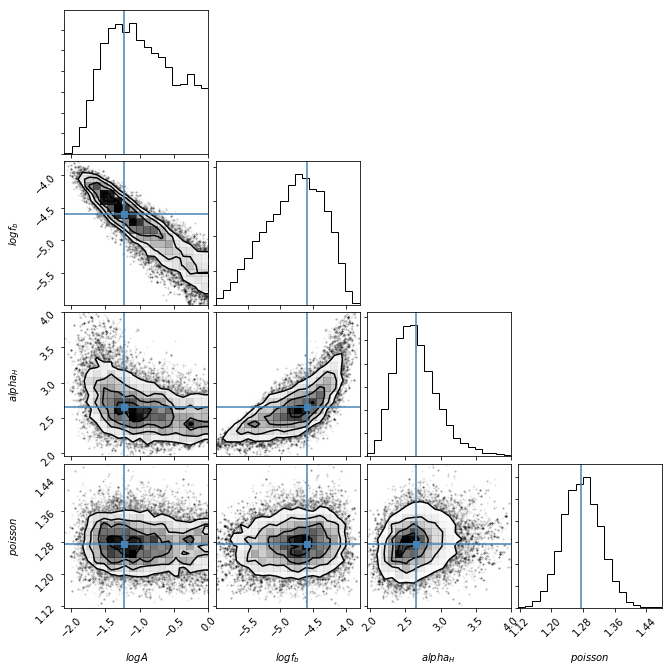

In [26]:
import corner
fig = corner.corner(samples, labels=["$log A$", "$log f_b$", "$alpha_H$", "$poisson$"],
                      truths=[m.values[0], m.values[1], m.values[2], m.values[3]])

In [10]:
def twi_minus_loglikelihood_nobreak(log_A,alpha,poisson):
    alpha_L = 1.0
    
    perdata091 = pd.read_csv("perlist092.csv")
    f = perdata091['f']
    per = perdata091['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append((f[i]**(-alpha))*(10**log_A)+poisson)
     
    
    length = len(perdata091)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [11]:
n=Minuit(twi_minus_loglikelihood_nobreak,log_A=-7,alpha=2.0,poisson=1.0,
         error_log_A=0.1,error_alpha=0.01,error_poisson=0.01,
         limit_log_A=(-9,-6),limit_alpha=(1.0,5.0),limit_poisson=(0,2),
         errordef=1)

n.migrad()

pprint(n.fval)
n.print_param()

FCN = 2223.832896867475 
 TOTAL NCALL = 91 
 NCALLS = 91 
 
 
 EDM = 0.00014363040127514338 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-8.04899,0.675227,,,-9,-6,No
1,alpha,2.4357,0.186908,,,1,5,No
2,poisson,1.27014,0.0477494,,,0,2,No


2223.832896867475


+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-8.04899,0.675227,,,-9,-6,No
1,alpha,2.4357,0.186908,,,1,5,No
2,poisson,1.27014,0.0477494,,,0,2,No


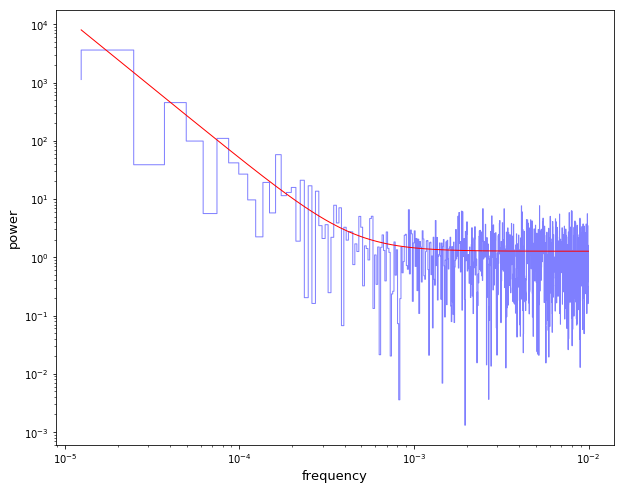

In [12]:
log_A,alpha,poisson = n.values[0],n.values[1],n.values[2]

model2 = []
f_length = len(f)
for i in range(f_length):
    model2.append((f[i]**(-alpha))*(10**log_A)+poisson)
    
plt.figure(figsize=(10,8))
plt.loglog()
plt.step(f, per, color="b", alpha=0.5, linewidth=1)
plt.plot(f, model2, color="r", linewidth=1)
plt.xlabel("frequency",fontsize=13)
plt.ylabel("power",fontsize=13)
plt.show()

In [13]:
# 对无截断幂律谱尝试emcee

# 均匀先验

def lnprior_nobreak(theta):
    log_A,alpha,poisson = theta
    if -10 < log_A < -5 and 1.0 < alpha < 4.0 and 0.0 < poisson < 2.0:
        return 0.0
    return -np.inf

# 后验概率？

def lnprob_nobreak(theta):
    log_A,alpha,poisson = theta
    lp = lnprior_nobreak(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp - 0.5* twi_minus_loglikelihood_nobreak(log_A,alpha,poisson))

In [14]:
# emcee

ndim, nwalkers = 3, 100
pos = [[n.values[0],n.values[1],n.values[2]] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler_nobreak = emcee.EnsembleSampler(nwalkers, ndim, lnprob_nobreak)


# 显示进度并记录时间
import sys

nsteps = 500
width = 30
start = time.time()
for i, result in enumerate(sampler_nobreak.sample(pos, iterations=nsteps)):
    z = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * z, ' ' * (width - z)))
sys.stdout.write("\n")
end = time.time()
multi_time = end - start
print("Serial took {0:.1f} seconds".format(multi_time))

[##############################]
Serial took 859.1 seconds


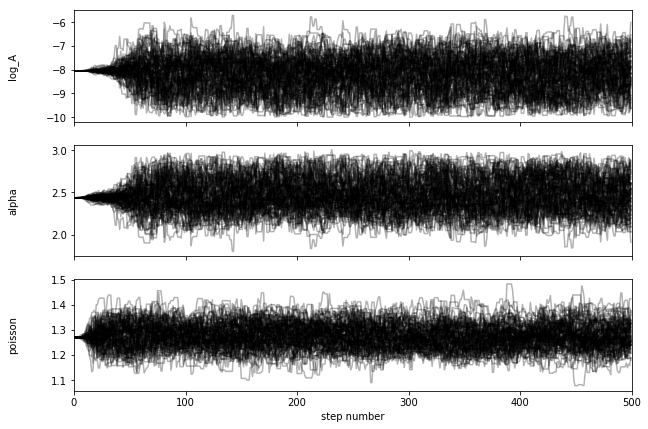

In [15]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples_nobreak = sampler_nobreak.chain
labels = ["log_A", "alpha","poisson"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.transpose(samples_nobreak[:,:,i]), "k", alpha=0.3)
    ax.set_xlim(0, len(samples_nobreak[1]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [16]:
samples_nobreak = sampler_nobreak.chain[:, 100:, :].reshape((-1, ndim))
labels = ["log_A", "alpha","poisson"]

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(samples_nobreak[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{{2:.7f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

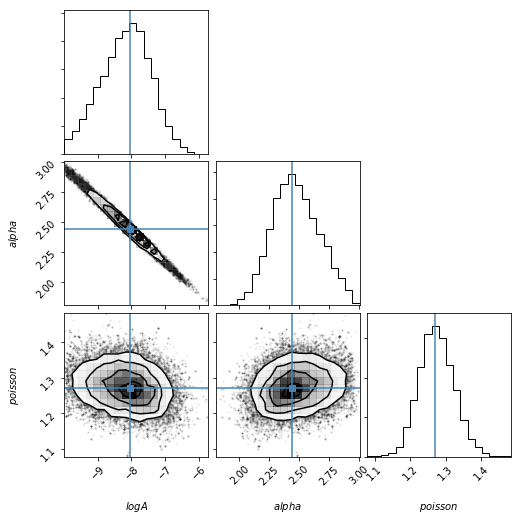

In [17]:
import corner
fig = corner.corner(samples_nobreak, labels=["$logA$", "$alpha$", "$poisson$"],
                        truths=[n.values[0], n.values[1], n.values[2]])

In [27]:
# T 大于0，则bending模型较好；小于0，则nobreak模型较好

T = m.fval-n.fval
print(T)

-0.7649749865722697
